# t-SNE met beelden

We gaan in dit labo een t-SNE representatie bouwen van de _UC Merced Land Use Dataset_ dataset.

Dit is een bekende benchmark dataset voor classificatie van luchtfoto's, ontwikkeld door de University of California, Merced. De dataset bevat:

- 2100 beelden van 256×256 pixels
- 21 categorieën (bijv. agricultural, airplane, beach, buildings, forest, freeway, harbor, parking lot, residential, etc.)
- 100 beelden per categorie

In [4]:
from datasets import load_dataset

UC_Merced = load_dataset("blanchon/UC_Merced")

## 1. Data inspectie

In [5]:
# Explore the dataset structure
print("Dataset structure:")
print(UC_Merced)
print(f"\nNumber of training images: {len(UC_Merced['train'])}")
print(f"\nFeatures: {UC_Merced['train'].features}")
print(f"\nCategories: {UC_Merced['train'].features['label'].names}")

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
})

Number of training images: 2100

Features: {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt'])}

Categories: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


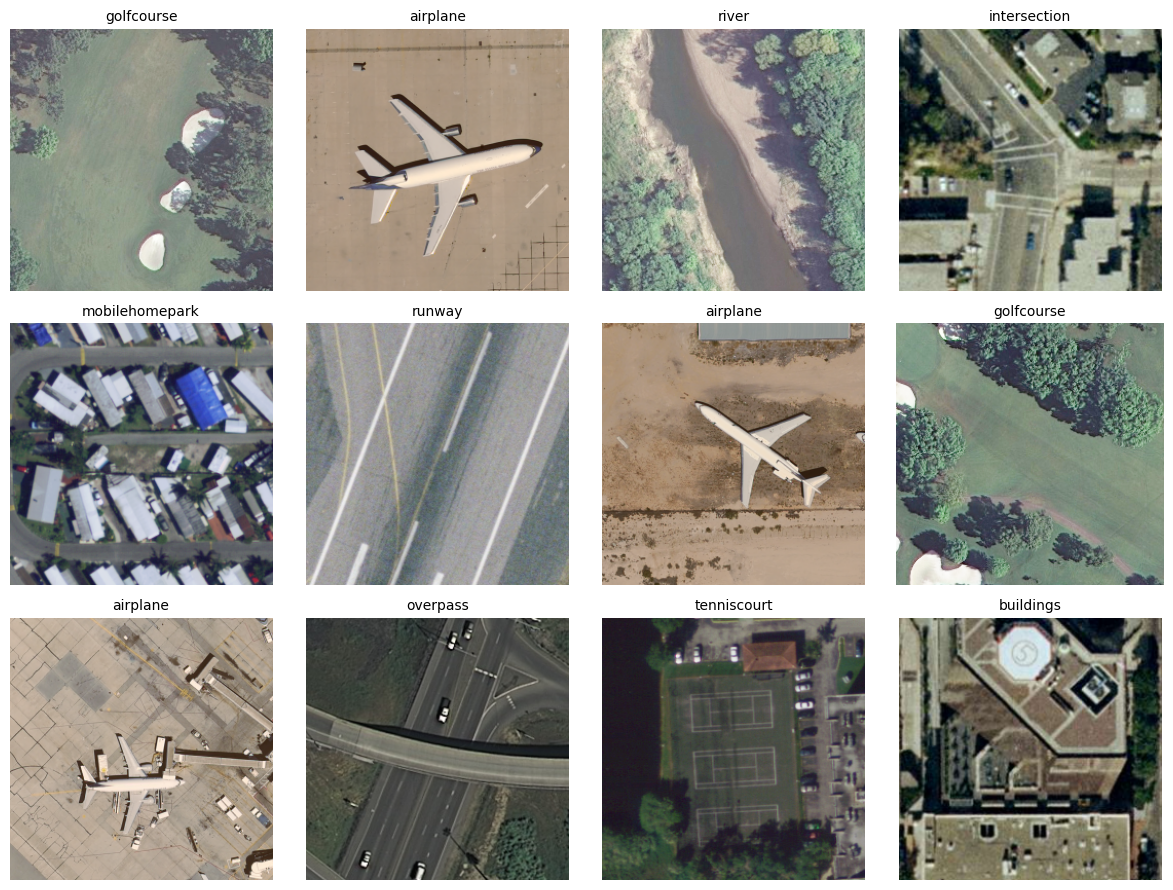

In [6]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng(42)

# Display a grid of sample images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

# Sample 12 random images
sample_indices = rng.choice(len(UC_Merced["train"]), size=12, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    sample = UC_Merced["train"][int(sample_idx)]
    axes[idx].imshow(sample["image"])
    label_name = UC_Merced["train"].features["label"].names[sample["label"]]
    axes[idx].set_title(f"{label_name}", fontsize=10)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 2. Embedding Model

We willen eerst de beelden omzetten naar bruikbare feature vectoren aan de hand van een beeld-embedding model. We kiezen voor een klein CNN model: MobileNetV2 getraind met [IMAGENET](https://www.image-net.org/). Via `torch.nn.Sequential(*list(mobilenet.children())[:-1])` verwijderen we de bovenste klassificatie layer.

In [7]:
import torch
from torchvision import models, transforms

# Load pre-trained MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=True)

# Remove the classifier layer to get embeddings
embedding_model = torch.nn.Sequential(*list(mobilenet.children())[:-1])
embedding_model.eval()

# Define image preprocessing
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # ImageNet normalisation values (mean/std calculated over ~1.2M training images)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

/opt/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Genereren van embeddings

We nemen een sample van 1000 beelden en sturen die door het embedding model.

In [8]:
# Sample 1000 images (stratified by category for better representation)
n_samples = 1000
dataset = UC_Merced["train"]

# Get all categories
categories = dataset.features["label"].names
n_categories = len(categories)
samples_per_category = n_samples // n_categories

# Sample indices stratified by category
sampled_indices = []
sampled_labels = []

for label_idx in range(n_categories):
    # Get all indices for this category
    category_indices = [i for i in range(len(dataset)) if dataset[i]["label"] == label_idx]
    # Sample from this category
    n_to_sample = min(samples_per_category, len(category_indices))
    sampled = rng.choice(category_indices, size=n_to_sample, replace=False)
    sampled_indices.extend(sampled)
    sampled_labels.extend([label_idx] * n_to_sample)

# Adjust to exactly 100 if needed
sampled_indices = sampled_indices[:n_samples]
sampled_labels = sampled_labels[:n_samples]

print(f"Sampled {len(sampled_indices)} images")
print(f"Categories distribution: {np.bincount(sampled_labels)}")

Sampled 987 images
Categories distribution: [47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47]


In [9]:
# Generate embeddings for the sampled images
embeddings_list = []

print("Generating embeddings...")
with torch.no_grad():
    for idx in sampled_indices:
        # Get image
        image = dataset[int(idx)]["image"]

        # Preprocess
        input_tensor = preprocess(image).unsqueeze(0)

        # Get embedding (output is [batch, 1280, 7, 7])
        embedding = embedding_model(input_tensor)

        # Apply global average pooling to get [batch, 1280]
        embedding = embedding.mean(dim=[2, 3])

        # Convert to numpy and flatten
        embedding = embedding.squeeze().numpy()
        embeddings_list.append(embedding)

embeddings_array = np.array(embeddings_list)
print(f"Embeddings shape: {embeddings_array.shape}")
print(f"Labels shape: {len(sampled_labels)}")

Generating embeddings...
Embeddings shape: (987, 1280)
Labels shape: 987
Embeddings shape: (987, 1280)
Labels shape: 987


## 4. Toepassing van t-SNE
Via t-SNE reduceren we de hoog-dimensionele embeddings (1280 dimensies) naar 2D vor de visualisatie.

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE
print("Applying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings_array)

print(f"\nReduced embeddings shape: {embeddings_2d.shape}")
print(f"X range: [{embeddings_2d[:, 0].min():.2f}, {embeddings_2d[:, 0].max():.2f}]")
print(f"Y range: [{embeddings_2d[:, 1].min():.2f}, {embeddings_2d[:, 1].max():.2f}]")

Applying t-SNE (this may take a moment)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 987 samples in 0.002s...
[t-SNE] Computed neighbors for 987 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 987 / 987
[t-SNE] Mean sigma: 5.857131
[t-SNE] Computed neighbors for 987 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 987 / 987
[t-SNE] Mean sigma: 5.857131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.859451
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.859451
[t-SNE] KL divergence after 1000 iterations: 0.836003

Reduced embeddings shape: (987, 2)
X range: [-41.03, 47.04]
Y range: [-33.70, 54.63]
[t-SNE] KL divergence after 1000 iterations: 0.836003

Reduced embeddings shape: (987, 2)
X range: [-41.03, 47.04]
Y range: [-33.70, 54.63]


## 5. Visualisatie

In [ ]:
import pandas as pd
import plotly.express as px

# Create a DataFrame for plotting
df = pd.DataFrame(
    {
        "x": embeddings_2d[:, 0],
        "y": embeddings_2d[:, 1],
        "label": [categories[label] for label in sampled_labels],
        "label_id": sampled_labels,
    }
)

# Create interactive scatter plot
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="label",
    title="t-SNE Visualization of UC Merced Land Use Dataset",
    labels={"x": "t-SNE Component 1", "y": "t-SNE Component 2"},
    hover_data=["label"],
    width=900,
    height=700,
)

# Update layout for better appearance
fig.update_traces(marker={"size": 10, "line": {"width": 0.5, "color": "white"}})
fig.update_layout(
    font=dict(size=12),
    legend={
        "title": "Land Use Category",
        "yanchor": "top",
        "y": 0.99,
        "xanchor": "left",
        "x": 1.01,
    },
)

fig.show()

## 6. _Perplexity_ Hyperparameter

Perplexity is een belangrijke hyperparameter in t-SNE die de balans bepaalt tussen lokale en globale structuur. Het kan worden gezien als het effectieve aantal buren dat elk punt heeft. Laten we verkennen hoe verschillende perplexity waarden de visualisatie beïnvloeden.

In [14]:
# Test different perplexity values
perplexity_values = [5, 15, 30, 50]
results = {}

print("Computing t-SNE with different perplexity values...")
for perp in perplexity_values:
    print(f"Perplexity = {perp}...", end=" ")
    tsne_temp = TSNE(n_components=2, random_state=42, perplexity=perp, max_iter=1000, verbose=0)
    embeddings_2d_temp = tsne_temp.fit_transform(embeddings_array)
    results[perp] = embeddings_2d_temp
    print("done")

print("All done!")

Computing t-SNE with different perplexity values...
Perplexity = 5... 

done
Perplexity = 15... done
Perplexity = 30... done
Perplexity = 30... done
Perplexity = 50... done
Perplexity = 50... done
All done!
done
All done!


In [15]:
# Create subplots comparing different perplexity values
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig_perplexity = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=[f"Perplexity = {p}" for p in perplexity_values],
    vertical_spacing=0.12,
    horizontal_spacing=0.08,
)

# Color mapping for categories
unique_labels = sorted(set(sampled_labels))
colors = px.colors.qualitative.Plotly + px.colors.qualitative.Dark24
color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for idx, (perp, pos) in enumerate(zip(perplexity_values, positions, strict=False)):
    embeddings_temp = results[perp]

    # Create scatter traces for each category
    for label_idx in unique_labels:
        mask = [l == label_idx for l in sampled_labels]
        indices = [i for i, m in enumerate(mask) if m]

        fig_perplexity.add_trace(
            go.Scatter(
                x=embeddings_temp[indices, 0],
                y=embeddings_temp[indices, 1],
                mode="markers",
                marker={
                    "size": 6,
                    "color": color_map[label_idx],
                    "line": {"width": 0.3, "color": "white"},
                },
                name=categories[label_idx],
                legendgroup=categories[label_idx],
                showlegend=(idx == 0),  # Only show legend for first subplot
                hovertemplate=f"{categories[label_idx]}<br>x: %{{x:.2f}}<br>y: %{{y:.2f}}<extra></extra>",
            ),
            row=pos[0],
            col=pos[1],
        )

fig_perplexity.update_xaxes(title_text="t-SNE 1", showticklabels=False)
fig_perplexity.update_yaxes(title_text="t-SNE 2", showticklabels=False)

fig_perplexity.update_layout(
    title_text="Effect of Perplexity on t-SNE Visualization",
    height=800,
    width=1000,
    font={"size": 11},
    legend={"yanchor": "top", "y": 0.98, "xanchor": "left", "x": 1.01, "font": {"size": 9}},
)

fig_perplexity.show()

### Perplexity begrijpen

**Perplexity** bepaalt de balans tussen lokale en globale aspecten van de data:

- **Lage perplexity (5-10)**: Focust op zeer lokale structuur. Je ziet veel kleine, compacte clusters. Kan fijnmazige lokale patronen onthullen maar kan gerelateerde groepen fragmenteren.

- **Medium perplexity (20-50)**: Aanbevolen bereik voor de meeste datasets. Balanceert lokale en globale structuur, toont zowel individuele clusters als hun onderlinge relaties.

- **Hoge perplexity (50+)**: Benadrukt globale structuur. Clusters kunnen samensmelten, maar je krijgt een beter beeld van de algemene data-organisatie.

**Richtlijnen:**
- Voor kleine datasets (< 100 samples): Gebruik perplexity 5-15
- Voor medium datasets (100-1000 samples): Gebruik perplexity 15-50
- Voor grote datasets (> 1000 samples): Gebruik perplexity 30-100

De vuistregel is: perplexity moet kleiner zijn dan het aantal datapunten, typisch tussen 5 en 50.